In [81]:
# Importing the recquired libraries:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import os
import cv2

import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline 

# Ignore harmless warnings:

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import platform
print(torch.__version__)
print(platform.python_version())

1.8.1+cu101
3.7.10


In [82]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [83]:
train_set = ['urjc', 'gavab'] * 400
test_set = ['urjc', 'gavab'] * 100
#train_set = words[0:32]*128
#print(train_set[0:32])
#import random
#random.seed(101)
#random.shuffle(train_set)
len_train = len(train_set)
len_test = len(test_set)
#print(train_set[0:15])

In [84]:
# Function to convert letters (and therefore words) into PyTorch tensors:

letters = ['SOS_token', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
          'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'EOS_token']

def letter_to_vector(letter):
    vector = torch.zeros(1, 1, len(letters))
    for i in range(len(letters)):
        if letters[i] == letter:
            vector[0, 0, i] = 1.
    return(vector)

print(letter_to_vector('SOS_token'))

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])


In [85]:
# Defining model and architecture:

# CONVOLUTIONAL NEURAL NETWORK:

class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1, 2) # padding???
        self.conv2 = nn.Conv2d(20, 50, 5, 1, 2)
        self.fc1 = nn.Linear(12*2*50, 1024)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 12*2*50) # -1 para no tener que determinar aquí el tamaño del batch (se ajusta, podemos variarlo)
        X = F.relu(self.fc1(X))

        return X 

In [86]:
# ENCODER:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(input_size, hidden_size)

    def forward(self, input, hidden):
        #embedded = self.embedding(input).view(1, 1, -1)
        output = input.view(1,1,-1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [87]:
# DECODER:

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        #self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = input.view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [88]:
# Instantiate the model, define loss and optimization functions:

torch.manual_seed(101)

input_size = 1024
hidden_size = 256
output_size = 28

CNN_model = ConvolutionalNetwork().cuda()
CNN_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.01)

Encoder_model = EncoderRNN(input_size = input_size, hidden_size = hidden_size).cuda()
Encoder_optimizer = optim.SGD(Encoder_model.parameters(), lr=0.01)

Decoder_model = DecoderRNN(hidden_size = hidden_size, output_size = output_size).cuda()
Decoder_optimizer = optim.SGD(Decoder_model.parameters(), lr=0.01)

#criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

In [91]:
# TRAINING THE MODEL:

import time
start_time = time.time()

# Setting the image parameters:

height = 48
width = 192

# Setting the sliding window parameters:

patch_height = 48
patch_width = 10
stepsize = 2
n_patches = int((width - patch_width)/2 + 1)

# Setting the sliding window parameters:

torch.manual_seed(101)
epochs = 15
train_losses = []


for i in range(epochs):
    
    for j in range(len_train): # we chose individual words/images as batches:
        
        CNN_optimizer.zero_grad()
        Encoder_optimizer.zero_grad()
        Decoder_optimizer.zero_grad()
        
        image = 255 * np.ones(shape=[height, width], dtype=np.uint8)
        image = cv2.putText(image, text = train_set[j], org=(5, 30),
        fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0,0,0),
        thickness=2, lineType=cv2.LINE_AA)
        
        image = transforms.ToPILImage()(image) # np.ndarray to PIL.Image.Image
        
        input_word = list(train_set[j])
        input_word_length = len(input_word) # number of letters
        
        encoder_hidden = Encoder_model.initHidden()
        
        
        for p in range(n_patches):
            
            patch = transforms.functional.crop(image, 0, 0 + p * stepsize, 48, 10) # cropping of the image into patches
            patch = transforms.ToTensor()(patch) # torch.Tensor of the patch (normalized)
            patch = 1. - patch
            patch = patch.view(1, 1, 48, 10) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
            patch = patch.type(torch.FloatTensor)
            patch = patch.cuda()

            encoder_input = CNN_model(patch).cuda() # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)
            
            _, encoder_hidden = Encoder_model(encoder_input, encoder_hidden)
            
        decoder_input = letter_to_vector('SOS_token').cuda()
        decoder_hidden = encoder_hidden
                
        
        for d in range(input_word_length):
            
            decoder_output, decoder_hidden = Decoder_model(decoder_input, decoder_hidden)
            #decoder_input = letter_to_vector(input_word[d])
            
            one_hot_decoder_output = torch.zeros(1, 1, output_size).cuda()
            one_hot_decoder_output[0][0][torch.argmax(decoder_output)] = 1.
            decoder_input = one_hot_decoder_output.cuda()
            
            if torch.equal(one_hot_decoder_output, letter_to_vector('EOS_token').cuda())==True:
                break
            
            if d == 0:
                
                output_word = decoder_output 
                one_hot_input_word = letter_to_vector(input_word[d]).type(torch.LongTensor)
                index = torch.argmax(one_hot_input_word.view(output_size))
                ground_word = torch.tensor([index], dtype = torch.long)
                
            else:
                
                output_word = torch.cat((output_word, decoder_output), dim = 0) # we concatenate the remaining output letters
                one_hot_input_word = torch.cat((one_hot_input_word,
                                       letter_to_vector(input_word[d]).type(torch.LongTensor)), dim = 0)

        
        one_hot_input_word = one_hot_input_word.view(-1, output_size)
        output_word = output_word.view(-1, output_size) 
        ground_word = torch.argmax(one_hot_input_word, dim = 1).cuda()
        loss = criterion(output_word, ground_word)
        
        loss.backward()
        
        CNN_optimizer.step()
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        
    train_losses.append(loss)
    print(i)
print(train_losses)
print(f'Duration: {(time.time() - start_time)/60} minutes')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[tensor(0.5789, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.3312, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.1274, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0561, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0327, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0053, device='cuda:0', grad_fn=<NllLossBackward>), tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward>)]
Duration: 35.05280257066091 minutes


Text(0.5, 1.0, 'Losses per epoch CNN-S2S only 2 words')

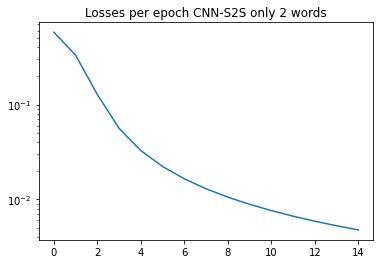

In [92]:
plt.yscale("log")
plt.plot(train_losses)
plt.title('Losses per epoch CNN-S2S only 2 words')

In [94]:
# EVALUATING THE MODEL:

import time
start_time = time.time()

# Setting the image parameters:

height = 48
width = 192

# Setting the sliding window parameters:

patch_height = 48
patch_width = 10 
stepsize = 2
n_patches = int((width - patch_width)/2 + 1)

input_word_test = 'gavab'

torch.manual_seed(101)

image_test = 255 * np.ones(shape=[height, width], dtype=np.uint8)
image_test = cv2.putText(image_test, text = input_word_test, org=(5, 30),
fontFace= cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.7, color=(0,0,0),
thickness=2, lineType=cv2.LINE_AA)

image_test = transforms.ToPILImage()(image_test) # np.ndarray to PIL.Image.Image

input_word_test = list(input_word_test)
input_word_test_length = len(input_word_test) # number of letters

with torch.no_grad():
      
      encoder_hidden_test = Encoder_model.initHidden()
      
      for p in range(n_patches):
          
          patch_test = transforms.functional.crop(image_test, 0, 0 + p * stepsize, 48, 10) # cropping of the image into patches
          patch_test = transforms.ToTensor()(patch_test) # torch.Tensor of the patch (normalized)
          patch_test = 1. - patch_test
          patch_test = patch_test.view(1, 1, 48, 10) # CNN_model expects a 4-dimensional tensor (1 dimension for batch)
          patch_test = patch_test.type(torch.FloatTensor)
          patch_test = patch_test.cuda()

          encoder_input_test = CNN_model(patch_test).cuda() # 1024-length vector associated to patch p (i.e. CNN output, Encoder input)
          
          _, encoder_hidden_test = Encoder_model(encoder_input_test, encoder_hidden_test)
          
      decoder_input_test = letter_to_vector('SOS_token').cuda()
      decoder_hidden_test = encoder_hidden_test
              
      
      for d in range(input_word_test_length):
          
          decoder_output_test, decoder_hidden_test = Decoder_model(decoder_input_test, decoder_hidden_test)
          #decoder_input = letter_to_vector(input_word[d])
          
          one_hot_decoder_output_test = torch.zeros(1, 1, output_size).cuda()
          one_hot_decoder_output_test[0][0][torch.argmax(decoder_output_test)] = 1.
          decoder_input_test = one_hot_decoder_output_test.cuda()
          
          if torch.equal(one_hot_decoder_output_test, letter_to_vector('EOS_token').cuda())==True:
              break
          
          if d == 0:
              
              output_word_test = decoder_output_test 
              one_hot_input_word_test = letter_to_vector(input_word_test[d]).type(torch.LongTensor)
              index_test = torch.argmax(one_hot_input_word_test.view(output_size))
              ground_word_test = torch.tensor([index_test], dtype = torch.long)
              
          else:
              
              output_word_test = torch.cat((output_word_test, decoder_output_test), dim = 0) # we concatenate the remaining output letters
              one_hot_input_word_test = torch.cat((one_hot_input_word_test,
                                      letter_to_vector(input_word_test[d]).type(torch.LongTensor)), dim = 0)

      
      one_hot_input_word_test = one_hot_input_word_test.view(-1, output_size)
      output_word_test = output_word_test.view(-1, output_size) 
      ground_word_test = torch.argmax(one_hot_input_word_test, dim = 1).cuda()


model_word = []

indices = torch.argmax(output_word_test, dim = 1)
for i in range(indices.numel()):
    model_word.append(letters[indices[i]])

model_word = ''.join(model_word)    
print(model_word)

        
print(f'Duration: {(time.time() - start_time)/60} minutes')

gavab
Duration: 0.0013917843500773112 minutes


In [ ]:
skimage.util.random_noise(img, mode='gaussian')

In [80]:
print(1. - patch_test1)
print(patch_test1)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0